In [1]:
import pandas as pd
import numpy as np
import gensim
import seaborn as sns

from gensim.models import KeyedVectors

import pset3_functions
from learn_decoder import *
from word2vec_utils import *
from pset3_functions import *
import matplotlib.pyplot as plt
import pickle
from decoder_utils import train_decoder, test_decoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from decoder_utils import get_rank
from sentence_transformers import SentenceTransformer

## Cross Lingual Semantic Decoding

In [2]:
data = read_matrix("downloads/pset3-files/imaging_data.csv", sep=",")
glove_vectors = read_matrix("downloads/pset3-files/vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('downloads/pset3-files/stimuli_180concepts.txt', dtype=np.dtype('U'))
w2v_model = load_word2vec_model()
w2v_vectors = create_concept_vectors(w2v_model, concepts)

['argumentatively']


In [3]:
def generate_embeddings_mbert(sentences, model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
    """
    Generate cross-lingual embeddings using multilingual BERT models
    
    Args:
        sentences: List of sentences (can be mixed languages including Arabic)
        model_name: Pre-trained multilingual model name
    
    Returns:
        numpy array of shape (len(sentences), embedding_dim)
    """
    model = SentenceTransformer(model_name)
    
    embeddings = model.encode(sentences, convert_to_tensor=False, show_progress_bar=True)
    
    return embeddings

# Alternative function using transformers library directly for more control
from transformers import AutoTokenizer, AutoModel
import torch

def generate_embeddings_mbert_transformers(sentences, model_name='bert-base-multilingual-cased'):
    """
    Generate embeddings using mBERT via transformers library
    
    Args:
        sentences: List of sentences (Arabic/multilingual)
        model_name: Multilingual BERT model name
    
    Returns:
        numpy array of embeddings
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    embeddings = []
    
    for sentence in sentences:
        # Tokenize and encode
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, 
                          padding=True, max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
            # Use [CLS] token embedding or mean pooling
            # [CLS] token (first token) embedding:
            cls_embedding = outputs.last_hidden_state[0, 0, :].numpy()
            # Or mean pooling:
            # mean_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
            
        embeddings.append(cls_embedding)
    
    return np.array(embeddings)

In [4]:
# concepts_eng_to_arabic = {
#     'ability': 'قدرة',
#     'accomplished': 'منجز',
#     'angry': 'غاضب',
#     'apartment': 'شقة',
#     'applause': 'تصفيق',
#     'argument': 'جدال',
#     'argumentatively': 'بجدلية',
#     'art': 'فن',
#     'attitude': 'موقف',
#     'bag': 'حقيبة',
#     'ball': 'كرة',
#     'bar': 'حانة',
#     'bear': 'دب',
#     'beat': 'يضرب',
#     'bed': 'سرير',
#     'beer': 'بيرة',
#     'big': 'كبير',
#     'bird': 'طائر',
#     'blood': 'دم',
#     'body': 'جسم',
#     'brain': 'دماغ',
#     'broken': 'مكسور',
#     'building': 'مبنى',
#     'burn': 'يحترق',
#     'business': 'عمل',
#     'camera': 'كاميرا',
#     'carefully': 'بحذر',
#     'challenge': 'تحدي',
#     'charity': 'خيرية',
#     'charming': 'ساحر',
#     'clothes': 'ملابس',
#     'cockroach': 'صرصور',
#     'code': 'رمز',
#     'collection': 'مجموعة',
#     'computer': 'حاسوب',
#     'construction': 'بناء',
#     'cook': 'يطبخ',
#     'counting': 'عدّ',
#     'crazy': 'مجنون',
#     'damage': 'ضرر',
#     'dance': 'رقص',
#     'dangerous': 'خطر',
#     'deceive': 'يخدع',
#     'dedication': 'تفانٍ',
#     'deliberately': 'عن عمد',
#     'delivery': 'توصيل',
#     'dessert': 'حلوى',
#     'device': 'جهاز',
#     'dig': 'يحفر',
#     'dinner': 'عشاء',
#     'disease': 'مرض',
#     'dissolve': 'يذوب',
#     'disturb': 'يزعج',
#     'do': 'يفعل',
#     'doctor': 'طبيب',
#     'dog': 'كلب',
#     'dressing': 'تتبيلة',
#     'driver': 'سائق',
#     'economy': 'اقتصاد',
#     'election': 'انتخابات',
#     'electron': 'إلكترون',
#     'elegance': 'أناقة',
#     'emotion': 'عاطفة',
#     'emotionally': 'عاطفياً',
#     'engine': 'محرك',
#     'event': 'حدث',
#     'experiment': 'تجربة',
#     'extremely': 'للغاية',
#     'feeling': 'شعور',
#     'fight': 'قتال',
#     'fish': 'سمكة',
#     'flow': 'تدفق',
#     'food': 'طعام',
#     'garbage': 'قمامة',
#     'gold': 'ذهب',
#     'great': 'عظيم',
#     'gun': 'سلاح',
#     'hair': 'شعر',
#     'help': 'مساعدة',
#     'hurting': 'يؤلم',
#     'ignorance': 'جهل',
#     'illness': 'مرض',
#     'impress': 'ينبهر',
#     'invention': 'اختراع',
#     'investigation': 'تحقيق',
#     'invisible': 'غير مرئي',
#     'job': 'وظيفة',
#     'jungle': 'غابة',
#     'kindness': 'لطف',
#     'king': 'ملك',
#     'lady': 'سيدة',
#     'land': 'أرض',
#     'laugh': 'ضحك',
#     'law': 'قانون',
#     'left': 'يسار',
#     'level': 'مستوى',
#     'liar': 'كاذب',
#     'light': 'ضوء',
#     'magic': 'سحر',
#     'marriage': 'زواج',
#     'material': 'مادة',
#     'mathematical': 'رياضي',
#     'mechanism': 'آلية',
#     'medication': 'دواء',
#     'money': 'مال',
#     'mountain': 'جبل',
#     'movement': 'حركة',
#     'movie': 'فيلم',
#     'music': 'موسيقى',
#     'nation': 'أمة',
#     'news': 'أخبار',
#     'noise': 'ضوضاء',
#     'obligation': 'التزام',
#     'pain': 'ألم',
#     'personality': 'شخصية',
#     'philosophy': 'فلسفة',
#     'picture': 'صورة',
#     'pig': 'خنزير',
#     'plan': 'خطة',
#     'plant': 'يزرع',
#     'play': 'مسرحية',
#     'pleasure': 'متعة',
#     'poor': 'فقير',
#     'prison': 'سجن',
#     'professional': 'محترف',
#     'protection': 'حماية',
#     'quality': 'جودة',
#     'reaction': 'رد فعل',
#     'read': 'يقرأ',
#     'relationship': 'علاقة',
#     'religious': 'ديني',
#     'residence': 'إقامة',
#     'road': 'طريق',
#     'sad': 'حزين',
#     'science': 'علم',
#     'seafood': 'مأكولات بحرية',
#     'sell': 'يبيع',
#     'sew': 'يخيط',
#     'sexy': 'جذاب',
#     'shape': 'شكل',
#     'ship': 'سفينة',
#     'show': 'يظهر',
#     'sign': 'إشارة',
#     'silly': 'سخيف',
#     'sin': 'خطيئة',
#     'skin': 'جلد',
#     'smart': 'ذكي',
#     'smiling': 'مبتسم',
#     'solution': 'حل',
#     'soul': 'روح',
#     'sound': 'صوت',
#     'spoke': 'تحدث',
#     'star': 'نجم',
#     'student': 'طالب',
#     'stupid': 'غبي',
#     'successful': 'ناجح',
#     'sugar': 'سكر',
#     'suspect': 'يشتبه',
#     'table': 'طاولة',
#     'taste': 'يتذوق',
#     'team': 'فريق',
#     'texture': 'ملمس',
#     'time': 'وقت',
#     'tool': 'أداة',
#     'toy': 'لعبة',
#     'tree': 'شجرة',
#     'trial': 'محاكمة',
#     'tried': 'حاول',
#     'typical': 'نموذجي',
#     'unaware': 'غير مدرك',
#     'usable': 'صالح للاستعمال',
#     'useless': 'عديم الفائدة',
#     'vacation': 'عطلة',
#     'war': 'حرب',
#     'wash': 'يغسل',
#     'weak': 'ضعيف',
#     'wear': 'يرتدي',
#     'weather': 'طقس',
#     'willingly': 'برغبة',
#     'word': 'كلمة'
# }


concepts_eng_to_arabic_hebrew = {
    'ability': ('قدرة', 'יכולת'),
    'accomplished': ('منجز', 'משיג'),
    'angry': ('غاضب', 'כועס'),
    'apartment': ('شقة', 'דירה'),
    'applause': ('تصفيق', 'מחיאות כפיים'),
    'argument': ('جدال', 'וויכוח'),
    'argumentatively': ('بجدلية', 'בויכוח'),
    'art': ('فن', 'אמנות'),
    'attitude': ('موقف', 'עמדה'),
    'bag': ('حقيبة', 'תיק'),
    'ball': ('كرة', 'כדור'),
    'bar': ('حانة', 'בר'),
    'bear': ('دب', 'דוב'),
    'beat': ('يضرب', 'להכות'),
    'bed': ('سرير', 'מיטה'),
    'beer': ('بيرة', 'בירה'),
    'big': ('كبير', 'גדול'),
    'bird': ('طائر', 'ציפור'),
    'blood': ('دم', 'דם'),
    'body': ('جسم', 'גוף'),
    'brain': ('دماغ', 'מוח'),
    'broken': ('مكسور', 'שבור'),
    'building': ('مبنى', 'בניין'),
    'burn': ('يحترق', 'לבעור'),
    'business': ('عمل', 'עסק'),
    'camera': ('كاميرا', 'מצלמה'),
    'carefully': ('بحذر', 'בזהירות'),
    'challenge': ('تحدي', 'אתגר'),
    'charity': ('خيرية', 'צדקה'),
    'charming': ('ساحر', 'חינני'),
    'clothes': ('ملابس', 'בגדים'),
    'cockroach': ('صرصور', "ג׳וק"),
    'code': ('رمز', 'קוד'),
    'collection': ('مجموعة', 'אוסף'),
    'computer': ('حاسوب', 'מחשב'),
    'construction': ('بناء', 'בנייה'),
    'cook': ('يطبخ', 'לבשל'),
    'counting': ('عدّ', 'ספירה'),
    'crazy': ('مجنون', 'משוגע'),
    'damage': ('ضرر', 'נזק'),
    'dance': ('رقص', 'ריקוד'),
    'dangerous': ('خطر', 'מסוכן'),
    'deceive': ('يخدع', 'להטעות'),
    'dedication': ('تفانٍ', 'התמסרות'),
    'deliberately': ('عن عمد', 'באופן מכוון'),
    'delivery': ('توصيل', 'משלוח'),
    'dessert': ('حلوى', 'קינוח'),
    'device': ('جهاز', 'מכשיר'),
    'dig': ('يحفر', 'לחפור'),
    'dinner': ('عشاء', 'ארוחה'),
    'disease': ('مرض', 'מחלה'),
    'dissolve': ('يذوب', 'להתמוסס'),
    'disturb': ('يزعج', 'לפריע'),
    'do': ('يفعل', 'לעשות'),
    'doctor': ('طبيب', 'רופא'),
    'dog': ('كلب', 'כלב'),
    'dressing': ('تتبيلة', 'תיבול'),
    'driver': ('سائق', 'נהג'),
    'economy': ('اقتصاد', 'כלכלה'),
    'election': ('انتخابات', 'בחירות'),
    'electron': ('إلكترون', 'אלקטרון'),
    'elegance': ('أناقة', 'אלגנטיות'),
    'emotion': ('عاطفة', 'רגש'),
    'emotionally': ('عاطفياً', 'רגשית'),
    'engine': ('محرك', 'מנוע'),
    'event': ('حدث', 'אירוע'),
    'experiment': ('تجربة', 'ניסוי'),
    'extremely': ('للغاية', 'באופן קיצוני'),
    'feeling': ('شعور', 'תחושה'),
    'fight': ('قتال', 'מאבק'),
    'fish': ('سمكة', 'דג'),
    'flow': ('تدفق', 'זרימה'),
    'food': ('طعام', 'אוכל'),
    'garbage': ('قمامة', 'זבל'),
    'gold': ('ذهب', 'זהב'),
    'great': ('عظيم', 'נהדר'),
    'gun': ('سلاح', 'רובה'),
    'hair': ('شعر', 'שיער'),
    'help': ('مساعدة', 'עזרה'),
    'hurting': ('يؤلم', 'פוצע'),
    'ignorance': ('جهل', 'בדלנות'),
    'illness': ('مرض', 'מחלה'),
    'impress': ('ينبهر', 'להרשים'),
    'invention': ('اختراع', 'המצאה'),
    'investigation': ('تحقيق', 'חקירה'),
    'invisible': ('غير مرئي', 'בלתי נראה'),
    'job': ('وظيفة', 'משרה'),
    'jungle': ('غابة', 'ג׳ונגל'),
    'kindness': ('لطف', 'נדיבות'),
    'king': ('ملك', 'מלך'),
    'lady': ('سيدة', 'גברת'),
    'land': ('أرض', 'אדמה'),
    'laugh': ('ضحك', 'צחוק'),
    'law': ('قانون', 'חוק'),
    'left': ('يسار', 'שמאל'),
    'level': ('مستوى', 'רמה'),
    'liar': ('كاذب', 'שקרן'),
    'light': ('ضوء', 'אור'),
    'magic': ('سحر', 'קסם'),
    'marriage': ('زواج', 'נישואין'),
    'material': ('مادة', 'חומר'),
    'mathematical': ('رياضي', 'מתמטי'),
    'mechanism': ('آلية', 'מנגנון'),
    'medication': ('دواء', 'תרופה'),
    'money': ('مال', 'כסף'),
    'mountain': ('جبل', 'הר'),
    'movement': ('حركة', 'תנועה'),
    'movie': ('فيلم', 'סרט'),
    'music': ('موسيقى', 'מוזיקה'),
    'nation': ('أمة', 'אומה'),
    'news': ('أخبار', 'חדשות'),
    'noise': ('ضوضاء', 'רעש'),
    'obligation': ('التزام', 'התחייבות'),
    'pain': ('ألم', 'כאב'),
    'personality': ('شخصية', 'אישיות'),
    'philosophy': ('فلسفة', 'פילוסופיה'),
    'picture': ('صورة', 'תמונה'),
    'pig': ('خنزير', 'חזיר'),
    'plan': ('خطة', 'תוכנית'),
    'plant': ('يزرع', 'לנטוע'),
    'play': ('مسرحية', 'הצגה'),
    'pleasure': ('متعة', 'הנאה'),
    'poor': ('فقير', 'עני'),
    'prison': ('سجن', 'כלא'),
    'professional': ('محترف', 'מקצועי'),
    'protection': ('حماية', 'הגנה'),
    'quality': ('جودة', 'איכות'),
    'reaction': ('رد فعل', 'תגובה'),
    'read': ('يقرأ', 'לקרוא'),
    'relationship': ('علاقة', 'קשר'),
    'religious': ('ديني', 'דתי'),
    'residence': ('إقامة', 'מגורים'),
    'road': ('طريق', 'דרך'),
    'sad': ('حزين', 'עצוב'),
    'science': ('علم', 'מדע'),
    'seafood': ('مأكولات بحرية', 'מאכלי ים'),
    'sell': ('يبيع', 'למכור'),
    'sew': ('يخيط', 'לתפור'),
    'sexy': ('جذاب', 'מושך'),
    'shape': ('شكل', 'צורה'),
    'ship': ('سفينة', 'ספינה'),
    'show': ('يظهر', 'להציג'),
    'sign': ('إشارة', 'סימן'),
    'silly': ('سخيف', 'מטופש'),
    'sin': ('خطيئة', 'חטא'),
    'skin': ('جلد', 'עור'),
    'smart': ('ذكي', 'חכם'),
    'smiling': ('مبتسم', 'מחייך'),
    'solution': ('حل', 'פתרון'),
    'soul': ('روح', 'נשמה'),
    'sound': ('صوت', 'צליל'),
    'spoke': ('تحدث', 'דיבר'),
    'star': ('نجم', 'כוכב'),
    'student': ('طالب', 'סטודנט'),
    'stupid': ('غبي', 'טיפש'),
    'successful': ('ناجح', 'מצליח'),
    'sugar': ('سكر', 'סוכר'),
    'suspect': ('يشتبه', 'להחשיד'),
    'table': ('طاولة', 'שולחן'),
    'taste': ('يتذوق', 'לטעום'),
    'team': ('فريق', 'קבוצה'),
    'texture': ('ملمس', 'מרקם'),
    'time': ('وقت', 'זמן'),
    'tool': ('أداة', 'כלי'),
    'toy': ('لعبة', 'צעצוע'),
    'tree': ('شجرة', 'עץ'),
    'trial': ('محاكمة', 'משפט'),
    'tried': ('حاول', 'ניסה'),
    'typical': ('نموذجي', 'טיפוסי'),
    'unaware': ('غير مدرك', 'לא מודע'),
    'usable': ('صالح للاستعمال', 'שימושי'),
    'useless': ('عديم الفائدة', 'חסר תועלת'),
    'vacation': ('عطلة', 'חופשה'),
    'war': ('حرب', 'מלחמה'),
    'wash': ('يغسل', 'לשטוף'),
    'weak': ('ضعيف', 'חלש'),
    'wear': ('يرتدي', 'ללבוש'),
    'weather': ('طقس', 'מזג אוויר'),
    'willingly': ('برغبة', 'ברצון'),
    'word': ('كلمة', 'מילה')
}

In [5]:
# # For ambiguous words, check which Arabic translation is closer to English
# for eng_word in ['dressing', 'left', 'light', 'plant', 'play', 'trial', 'show', 'suspect', 'taste', 'bear', 'bar']:
#     eng_embed = english_mbert[english_mbert.index(eng_word)]
    
#     # Get all Arabic translations
#     arabic_translations = concepts_eng_to_arabic[eng_word].split('/')
    
#     for ar_word in arabic_translations:
#         ar_embed = generate_embeddings_mbert_transformers([ar_word.strip()])[0]
#         similarity = cosine_similarity(eng_embed, ar_embed)
#         print(f"{eng_word} → {ar_word}: {similarity:.3f}")
        
        
        
# Assuming you have the word order that was used to create english_mbert
# ambig_english_words = [key for key, val in concepts_eng_to_arabic.items() if '/' in val]

# english_word_to_idx = {word: idx for idx, word in enumerate(ambig_english_words)}

# # For ambiguous words, check which Arabic translation is closer to English
# for eng_word in ambig_english_words:
#     eng_embed = english_mbert[english_word_to_idx[eng_word]]
    
#     # Get all Arabic translations
#     arabic_translations = concepts_eng_to_arabic[eng_word].split('/')
    
#     for ar_word in arabic_translations:
#         ar_embed = generate_embeddings_mbert_transformers([ar_word.strip()])[0]
#         similarity = cosine_similarity(eng_embed, ar_embed)
#         print(f"{eng_word} → {ar_word}: {similarity:.3f}")

In [6]:
# english_mbert = generate_embeddings_mbert_transformers(concepts)
# arabic_mbert = generate_embeddings_mbert_transformers(list(concepts_eng_to_arabic.values()))

# english_mbert = generate_embeddings_mbert_transformers(concepts)
# arabic_mbert = generate_embeddings_mbert_transformers(list(concepts_eng_to_arabic.values()))


english_concepts = list(concepts_eng_to_arabic_hebrew.keys())
arabic_concepts = [translations[0] for translations in concepts_eng_to_arabic_hebrew.values()]  
hebrew_concepts = [translations[1] for translations in concepts_eng_to_arabic_hebrew.values()]


english_mbert = generate_embeddings_mbert_transformers(english_concepts)
arabic_mbert = generate_embeddings_mbert_transformers(arabic_concepts)
hebrew_mbert = generate_embeddings_mbert_transformers(hebrew_concepts)

In [ ]:
language_embeddings = {
    'english': english_mbert,
    'arabic': arabic_mbert,
    'hebrew': hebrew_mbert
}

In [8]:
from sklearn.model_selection import KFold
def cross_validate_2models(fmri_data, english_vectors, arabic_vectors, n_folds=10, random_state=42):
    """
    Cross-validate decoder performance on two embedding spaces
    Returns:
        tuple: (english_mean, english_std, arabic_mean, arabic_std, fold_results)
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    fold_results = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(fmri_data)):
        # Handle both DataFrame and numpy array
        if hasattr(fmri_data, "iloc"):
            train_fmri = fmri_data.iloc[train_idx].values
            test_fmri = fmri_data.iloc[test_idx].values
        else:
            train_fmri = fmri_data[train_idx]
            test_fmri = fmri_data[test_idx]
        train_vectors = english_vectors[train_idx]
        test_english_vectors = english_vectors[test_idx]
        test_arabic_vectors = arabic_vectors[test_idx]
        # Train decoder
        decoder = train_decoder(train_fmri, train_vectors)
        # Test decoder on both embedding spaces
        english_results = test_decoder(test_fmri, test_english_vectors, decoder)
        arabic_results = test_decoder(test_fmri, test_arabic_vectors, decoder)
        fold_results.append(
            {
                "fold": fold + 1,
                "english_accuracy": english_results["mean_accuracy"],
                "arabic_accuracy": arabic_results["mean_accuracy"],
                "test_indices": test_idx,
            }
        )
    english_accuracies = [r["english_accuracy"] for r in fold_results]
    arabic_accuracies = [r["arabic_accuracy"] for r in fold_results]
    return np.mean(english_accuracies), np.std(english_accuracies), np.mean(arabic_accuracies), np.std(arabic_accuracies), fold_results

In [9]:
english_mean, english_std, arabic_mean, arabic_std, fold_results = cross_validate_2models(data, english_mbert, arabic_mbert, random_state=42)

print(f"English benchmark accuracy: {english_mean:.4f} ± {english_std:.4f}")
print(f"Cross-lingual accuracy: {arabic_mean:.4f} ± {arabic_std:.4f}")
print(f"Cross-lingual drop: {english_mean - arabic_mean:.4f}")

English benchmark accuracy: 0.5438 ± 0.0409
Cross-lingual accuracy: 0.5330 ± 0.0287
Cross-lingual drop: 0.0108


In [20]:
def cross_validate_multilingual(fmri_data, language_embeddings_dict, concepts, n_folds=10, random_state=42):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    fold_results = []
    concept_results = {lang: [] for lang in language_embeddings_dict.keys()}
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(fmri_data)):
        if hasattr(fmri_data, "iloc"):
            train_fmri = fmri_data.iloc[train_idx].values
            test_fmri = fmri_data.iloc[test_idx].values
        else:
            train_fmri = fmri_data[train_idx]
            test_fmri = fmri_data[test_idx]
        
        train_vectors = language_embeddings_dict['english'][train_idx]
        decoder = train_decoder(train_fmri, train_vectors)
        
        fold_result = {"fold": fold + 1}
        for lang_name, lang_vectors in language_embeddings_dict.items():
            test_vectors = lang_vectors[test_idx]
            results = test_decoder(test_fmri, test_vectors, decoder)
            fold_result[f"{lang_name}_accuracy"] = results["mean_accuracy"]
            
            # Track individual concept results
            for i, concept_idx in enumerate(test_idx):
                concept_name = concepts[concept_idx]
                concept_accuracy = results['sentence_accuracies'][i]  # individual accuracy
                concept_results[lang_name].append((concept_name, concept_accuracy))
        
        fold_results.append(fold_result)
    
    # Create DataFrames for each language
    language_dfs = {}
    for lang_name, concept_list in concept_results.items():
        df = pd.DataFrame(concept_list, columns=["concept", "accuracy"])
        mean_accuracies = df.groupby("concept").mean().sort_values("accuracy", ascending=False)
        language_dfs[lang_name] = mean_accuracies
    
    # Calculate overall means and stds
    language_results = {}
    for lang_name in language_embeddings_dict.keys():
        accuracies = [r[f"{lang_name}_accuracy"] for r in fold_results]
        language_results[lang_name] = (np.mean(accuracies), np.std(accuracies))
    
    return language_results, fold_results, language_dfs

In [21]:
results, fold_results, concept_dfs = cross_validate_multilingual(data, language_embeddings, concepts)

for lang, (mean_acc, std_acc) in results.items():
    print(f"{lang.capitalize()} accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

English accuracy: 0.5438 ± 0.0409
Arabic accuracy: 0.5330 ± 0.0287
Hebrew accuracy: 0.5556 ± 0.0470
Spanish accuracy: 0.5853 ± 0.0268
French accuracy: 0.5324 ± 0.0421


In [22]:
results, fold_results, concept_dfs = cross_validate_multilingual(data, language_embeddings, concepts)

for lang_name, df in concept_dfs.items():
    print(f"\n{lang_name.upper()} - Best decoded concepts:")
    print(df.head(10))
    print(f"\n{lang_name.upper()} - Worst decoded concepts:")
    print(df.tail(10))


ENGLISH - Best decoded concepts:
           accuracy
concept            
job             1.0
texture         1.0
road            1.0
charming        1.0
garbage         1.0
play            1.0
impress         1.0
invention       1.0
fish            1.0
extremely       1.0

ENGLISH - Worst decoded concepts:
             accuracy
concept              
spoke             0.0
trial             0.0
carefully         0.0
emotionally       0.0
war               0.0
prison            0.0
movie             0.0
material          0.0
election          0.0
read              0.0

ARABIC - Best decoded concepts:
          accuracy
concept           
noise          1.0
time           1.0
feeling        1.0
flow           1.0
gun            1.0
material       1.0
plan           1.0
sound          1.0
bear           1.0
election       1.0

ARABIC - Worst decoded concepts:
               accuracy
concept                
mathematical        0.0
investigation       0.0
philosophy          0.0
usable      

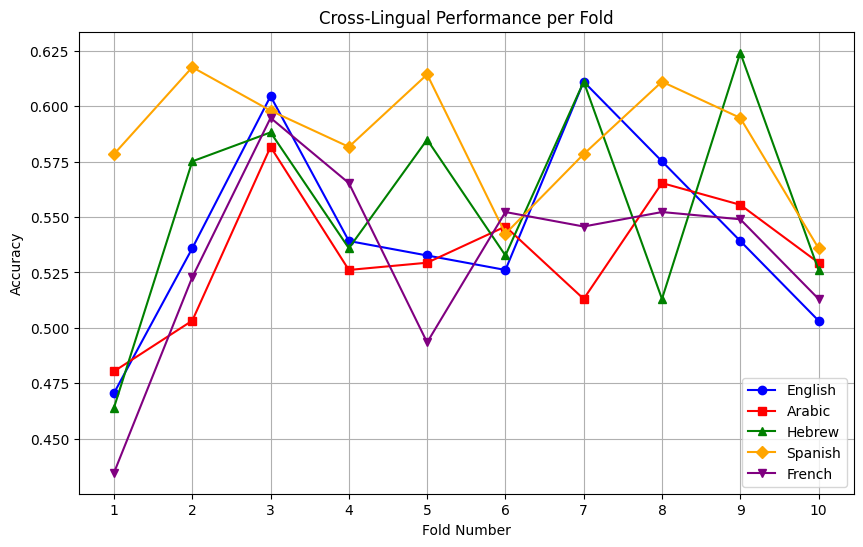

In [23]:
def plot_multilingual_performance(fold_results, languages):
    """Plot accuracy across folds for each language"""
    plt.figure(figsize=(10, 6))
    
    fold_numbers = [r['fold'] for r in fold_results]
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    markers = ['o', 's', '^', 'D', 'v']
    
    for i, lang in enumerate(languages):
        accuracies = [r[f'{lang}_accuracy'] for r in fold_results]
        plt.plot(fold_numbers, accuracies, 
                marker=markers[i % len(markers)], 
                label=lang.capitalize(),
                color=colors[i % len(colors)])
    
    plt.xlabel("Fold Number")
    plt.ylabel("Accuracy")
    plt.title("Cross-Lingual Performance per Fold")
    plt.xticks(fold_numbers)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_multilingual_performance(fold_results, list(language_embeddings.keys()))

In [24]:
concepts_translations = {
    'ability':      ('قدرة',       'יכולת',     'habilidad',     'habilité'),
    'accomplished': ('منجز',       'משיג',      'realizado',     'accompli'),
    'angry':        ('غاضب',       'כועס',       'enojado',       'en colère'),
    'apartment':    ('شقة',        'דירה',       'apartamento',   'appartement'),
    'applause':     ('تصفيق',      'מחיאות כפיים', 'aplauso',     'applaudissements'),
    'argument':     ('جدال',       'וויכוח',      'discusión',    'argument'),
    'argumentatively':('بجدلية','בויכוח',     'argumentativamente','de manière argumentative'),
    'art':          ('فن',         'אמנות',      'arte',         'art'),
    'attitude':     ('موقف',       'עמדה',       'actitud',      'attitude'),
    'bag':          ('حقيبة',      'תיק',        'bolsa',        'sac'),
    'ball':         ('كرة',        'כדור',       'pelota',       'balle'),
    'bar':          ('حانة',       'בר',         'bar',          'bar'),
    'bear':         ('دب',         'דוב',        'oso',          'ours'),
    'beat':         ('يضرب',       'להכות',      'golpear',      'battre'),
    'bed':          ('سرير',       'מיטה',       'cama',         'lit'),
    'beer':         ('بيرة',       'בירה',       'cerveza',      'bière'),
    'big':          ('كبير',       'גדול',       'grande',       'grand'),
    'bird':         ('طائر',       'ציפור',      'pájaro',       'oiseau'),
    'blood':        ('دم',         'דם',         'sangre',       'sang'),
    'body':         ('جسم',        'גוף',        'cuerpo',       'corps'),
    'brain':        ('دماغ',       'מוח',        'cerebro',      'cerveau'),
    'broken':       ('مكسور',       'שבור',       'roto',         'cassé'),
    'building':     ('مبنى',       'בניין',      'edificio',     'bâtiment'),
    'burn':         ('يحترق',      'לבעור',      'quemar',       'brûler'),
    'business':     ('عمل',        'עסק',        'negocio',      'entreprise'),
    'camera':       ('كاميرا',     'מצלמה',      'cámara',       'appareil photo'),
    'carefully':    ('بحذر',       'בזהירות',    'cuidadosamente','soigneusement'),
    'challenge':    ('تحدي',       'אתגר',       'desafío',      'défi'),
    'charity':      ('خيرية',      'צדקה',       'caridad',      'charité'),
    'charming':     ('ساحر',       'חינני',      'encantador',   'charmant'),
    'clothes':      ('ملابس',      'בגדים',      'ropa',         'vêtements'),
    'cockroach':    ('صرصور',      'ג\'וק',       'cucaracha',    'cafard'),
    'code':         ('رمز',        'קוד',         'código',       'code'),
    'collection':   ('مجموعة',     'אוסף',       'colección',    'collection'),
    'computer':     ('حاسوب',      'מחשב',       'ordenador',    'ordinateur'),
    'construction': ('بناء',       'בנייה',      'construcción', 'construction'),
    'cook':         ('يطبخ',       'לבשל',       'cocinar',      'cuisiner'),
    'counting':     ('عدّ',        'ספירה',      'conteo',       'comptage'),
    'crazy':        ('مجنون',      'משוגע',      'loco',         'fou'),
    'damage':       ('ضرر',        'נזק',        'daño',         'dommage'),
    'dance':        ('رقص',        'ריקוד',      'baile',        'danse'),
    'dangerous':    ('خطر',        'מסוכן',      'peligroso',    'dangereux'),
    'deceive':      ('يخدع',       'להטעות',     'engañar',      'tromper'),
    'dedication':   ('تفانٍ',      'התמסרות',    'dedicación',   'dévouement'),
    'deliberately': ('عن عمد',     'באופן מכוון','deliberadamente','délibérément'),
    'delivery':     ('توصيل',      'משלוח',      'entrega',      'livraison'),
    'dessert':      ('حلوى',       'קינוח',      'postre',       'dessert'),
    'device':       ('جهاز',       'מכשיר',      'dispositivo',  'appareil'),
    'dig':          ('يحفر',       'לחפור',      'cavar',        'creuser'),
    'dinner':       ('عشاء',       'ארוחה',      'cena',         'dîner'),
    'disease':      ('مرض',        'מחלה',       'enfermedad',   'maladie'),
    'dissolve':     ('يذوب',       'להתמוסס',    'disolver',     'dissoudre'),
    'disturb':      ('يزعج',       'לפריע',      'molestar',     'déranger'),
    'do':           ('يفعل',       'לעשות',      'hacer',        'faire'),
    'doctor':       ('طبيب',       'רופא',       'médico',       'médecin'),
    'dog':          ('كلب',        'כלב',         'perro',        'chien'),
    'dressing':     ('تتبيلة',     'תיבול',      'aderezo',      'assaisonnement'),
    'driver':       ('سائق',       'נהג',        'conductor',    'conducteur'),
    'economy':      ('اقتصاد',     'כלכלה',      'economía',     'économie'),
    'election':     ('انتخابات',    'בחירות',     'elección',     'élection'),
    'electron':     ('إلكترون',    'אלקטרון',     'electrón',     'électron'),
    'elegance':     ('أناقة',      'אלגנטיות',   'elegancia',    'élégance'),
    'emotion':      ('عاطفة',      'רגש',        'emoción',      'émotion'),
    'emotionally':  ('عاطفياً',     'רגשית',      'emocionalmente','émotionnellement'),
    'engine':       ('محرك',       'מנוע',       'motor',        'moteur'),
    'event':        ('حدث',        'אירוע',      'evento',       'événement'),
    'experiment':   ('تجربة',      'ניסוי',      'experimento',  'expérience'),
    'extremely':    ('للغاية',     'באופן קיצוני','extremadamente','extrêmement'),
    'feeling':      ('شعور',       'תחושה',      'sentimiento',  'sentiment'),
    'fight':        ('قتال',       'מאבק',       'lucha',        'combat'),
    'fish':         ('سمكة',       'דג',          'pez',          'poisson'),
    'flow':         ('تدفق',       'זרימה',      'flujo',        'flux'),
    'food':         ('طعام',       'אוכל',        'comida',       'nourriture'),
    'garbage':      ('قمامة',      'זבל',         'basura',       'ordures'),
    'gold':         ('ذهب',        'זהב',         'oro',          'or'),
    'great':        ('عظيم',       'נהדר',        'genial',       'génial'),
    'gun':          ('سلاح',       'רובה',        'arma',         'arme'),
    'hair':         ('شعر',        'שיער',        'cabello',      'cheveux'),
    'help':         ('مساعدة',     'עזרה',        'ayuda',        'aide'),
    'hurting':      ('يؤلم',       'פוצע',        'dolorido',     'blessé'),
    'ignorance':    ('جهل',        'בדלנות',      'ignorancia',   'ignorance'),
    'illness':      ('مرض',        'מחלה',        'enfermedad',   'maladie'),
    'impress':      ('ينبهر',       'להרשים',      'impresionar',  'impressionner'),
    'invention':    ('اختراع',     'המצאה',       'inventо',      'invention'),
    'investigation':('تحقيق',      'חקירה',       'investigación','enquête'),
    'invisible':    ('غير مرئي',    'בלתי נראה',   'invisible',    'invisible'),
    'job':          ('وظيفة',      'משרה',        'trabajo',      'emploi'),
    'jungle':       ('غابة',       'ג׳ונגל',      'jungla',       'jungle'),
    'kindness':     ('لطف',        'נדיבות',      'amabilidad',   'gentillesse'),
    'king':         ('ملك',        'מלך',         'rey',          'roi'),
    'lady':         ('سيدة',       'גברת',       'dama',         'dame'),
    'land':         ('أرض',        'אדמה',        'tierra',       'terre'),
    'laugh':        ('ضحك',        'צחוק',        'risa',         'rire'),
    'law':          ('قانون',      'חוק',         'ley',          'loi'),
    'left':         ('يسار',       'שמאל',        'izquierda',    'gauche'),
    'level':        ('مستوى',      'רמה',         'nivel',        'niveau'),
    'liar':         ('كاذب',       'שקרן',       'mentiroso',    'menteur'),
    'light':        ('ضوء',        'אור',          'luz',          'lumière'),
    'magic':        ('سحر',        'קסם',         'magia',        'magie'),
    'marriage':     ('زواج',       'נישואין',     'matrimonio',   'mariage'),
    'material':     ('مادة',       'חומר',        'material',     'matériel'),
    'mathematical': ('رياضي',      'מתמטי',       'matemático',   'mathématique'),
    'mechanism':    ('آلية',       'מנגנון',      'mecanismo',    'mécanisme'),
    'medication':   ('دواء',        'תרופה',       'medicación',   'médicament'),
    'money':        ('مال',        'כסף',         'dinero',       'argent'),
    'mountain':     ('جبل',        'הר',          'montaña',      'montagne'),
    'movement':     ('حركة',       'תנועה',       'movimiento',   'mouvement'),
    'movie':        ('فيلم',       'סרט',         'película',     'film'),
    'music':        ('موسيقى',     'מוזיקה',      'música',       'musique'),
    'nation':       ('أمة',        'אומה',        'nación',       'nation'),
    'news':         ('أخبار',      'חדשות',      'noticias',     'nouvelles'),
    'noise':        ('ضوضاء',      'רעש',         'ruido',        'bruit'),
    'obligation':   ('التزام',     'התחייבות',    'obligación',   'obligation'),
    'pain':         ('ألم',        'כאב',         'dolor',        'douleur'),
    'personality':  ('شخصية',      'אישיות',      'personalidad', 'personnalité'),
    'philosophy':   ('فلسفة',      'פילוסופיה',   'filosofía',    'philosophie'),
    'picture':      ('صورة',       'תמונה',       'imagen',       'image'),
    'pig':          ('خنزير',      'חזיר',        'cerdo',        'cochon'),
    'plan':         ('خطة',        'תוכנית',      'plan',         'plan'),
    'plant':        ('يزرع',       'לנטוע',       'plantar',      'planter'),
    'play':         ('مسرحية',     'הצגה',        'obra',         'pièce'),
    'pleasure':     ('متعة',       'הנאה',        'placer',       'plaisir'),
    'poor':         ('فقير',       'עני',         'pobre',        'pauvre'),
    'prison':       ('سجن',        'כלא',         'prisión',      'prison'),
    'professional': ('محترف',      'מקצועי',      'profesional',  'professionnel'),
    'protection':   ('حماية',      'הגנה',        'protección',   'protection'),
    'quality':      ('جودة',       'איכות',       'calidad',      'qualité'),
    'reaction':     ('رد فعل',      'תגובה',       'reacción',     'réaction'),
    'read':         ('يقرأ',       'לקרוא',       'leer',         'lire'),
    'relationship': ('علاقة',      'קשר',         'relación',     'relation'),
    'religious':    ('ديني',       'דתי',         'religioso',    'religieux'),
    'residence':    ('إقامة',      'מגורים',      'residencia',   'résidence'),
    'road':         ('طريق',       'דרך',         'carretera',    'route'),
    'sad':          ('حزين',       'עצוב',        'triste',       'triste'),
    'science':      ('علم',        'מדע',         'ciencia',      'science'),
    'seafood':      ('مأكولات بحرية','מאכלי ים','mariscos',     'fruits de mer'),
    'sell':         ('يبيع',       'למכור',       'vender',       'vendre'),
    'sew':          ('يخيط',       'לתפור',       'coser',        'coudre'),
    'sexy':         ('جذاب',       'מושך',        'sexy',         'sexy'),
    'shape':        ('شكل',        'צורה',        'forma',        'forme'),
    'ship':         ('سفينة',      'ספינה',       'barco',        'navire'),
    'show':         ('يظهر',       'להציג',      'mostrar',      'montrer'),
    'sign':         ('إشارة',      'סימן',        'señal',        'signe'),
    'silly':        ('سخيف',       'מטופש',       'tonto',        'sot'),
    'sin':          ('خطيئة',      'חטא',         'pecado',       'péché'),
    'skin':         ('جلد',        'עור',         'piel',         'peau'),
    'smart':        ('ذكي',        'חכם',         'inteligente',  'intelligent'),
    'smiling':      ('مبتسم',      'מחייך',       'sonriente',    'souriant'),
    'solution':     ('حل',         'פתרון',       'solución',     'solution'),
    'soul':         ('روح',        'נשמה',        'alma',         'âme'),
    'sound':        ('صوت',        'צליל',        'sonido',       'son'),
    'spoke':        ('تحدث',       'דיבר',        'habló',        'a parlé'),
    'star':         ('نجم',        'כוכב',        'estrella',     'étoile'),
    'student':      ('طالب',       'סטודנט',      'estudiante',   'étudiant'),
    'stupid':       ('غبي',        'טיפש',       'estúpido',     'stupide'),
    'successful':   ('ناجح',       'מצליח',       'exitoso',      'réussi'),
    'sugar':        ('سكر',        'סוכר',        'azúcar',       'sucre'),
    'suspect':      ('يشتبه',      'להחשיד',     'sospechar',    'suspecter'),
    'table':        ('طاولة',      'שולחן',       'mesa',         'table'),
    'taste':        ('يتذوق',      'לטעום',       'probar',       'goûter'),
    'team':         ('فريق',       'קבוצה',       'equipo',       'équipe'),
    'texture':      ('ملمس',       'מרקם',        'textura',      'texture'),
    'time':         ('وقت',        'זמן',         'tiempo',       'temps'),
    'tool':         ('أداة',       'כלי',         'herramienta',  'outil'),
    'toy':          ('لعبة',       'צעצוע',       'juguete',      'jouet'),
    'tree':         ('شجرة',       'עץ',          'árbol',        'arbre'),
    'trial':        ('محاكمة',     'משפט',        'juicio',       'procès'),
    'tried':        ('حاول',       'ניסה',        'intentó',      'essayé'),
    'typical':      ('نموذجي',     'טיפוסי',      'típico',       'typique'),
    'unaware':      ('غير مدرك',    'לא מודע',     'inconsciente', 'inconscient'),
    'usable':       ('صالح للاستعمال','שימושי',    'utilizable',   'utilisable'),
    'useless':      ('عديم الفائدة','חסר תועלת',  'inútil',       'inutile'),
    'vacation':     ('عطلة',       'חופשה',       'vacaciones',   'vacances'),
    'war':          ('حرب',        'מלחמה',       'guerra',       'guerre'),
    'wash':         ('يغسل',       'לשטוף',       'lavar',        'laver'),
    'weak':         ('ضعيف',       'חלש',         'débil',        'faible'),
    'wear':         ('يرتدي',      'ללבוש',       'vestir',       'porter'),
    'weather':      ('طقس',        'מזג אוויר',   'clima',        'temps'),
    'willingly':    ('برغبة',       'ברצון',       'de buena gana','volontiers'),
    'word':         ('كلمة',       'מילה',        'palabra',      'mot'),
}


In [25]:
english_concepts = list(concepts_translations.keys())
arabic_concepts = [translations[0] for translations in concepts_translations.values()]  
hebrew_concepts = [translations[1] for translations in concepts_translations.values()]
spanish_concepts = [translations[2] for translations in concepts_translations.values()]  
french_concepts = [translations[3] for translations in concepts_translations.values()]


english_mbert = generate_embeddings_mbert_transformers(english_concepts)
arabic_mbert = generate_embeddings_mbert_transformers(arabic_concepts)
hebrew_mbert = generate_embeddings_mbert_transformers(hebrew_concepts)
spanish_mbert = generate_embeddings_mbert_transformers(spanish_concepts)
french_mbert = generate_embeddings_mbert_transformers(french_concepts)

language_embeddings = {
    'english': english_mbert,
    'arabic': arabic_mbert,
    'hebrew': hebrew_mbert,
    'spanish': spanish_mbert,
    'french': french_mbert
}

In [29]:
results, fold_results, concept_dfs = cross_validate_multilingual(data, language_embeddings, concepts, n_folds=18)

for lang, (mean_acc, std_acc) in results.items():
    print(f"{lang.capitalize()} accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

English accuracy: 0.5543 ± 0.0605
Arabic accuracy: 0.5327 ± 0.0663
Hebrew accuracy: 0.5463 ± 0.0740
Spanish accuracy: 0.5790 ± 0.0534
French accuracy: 0.5333 ± 0.0581


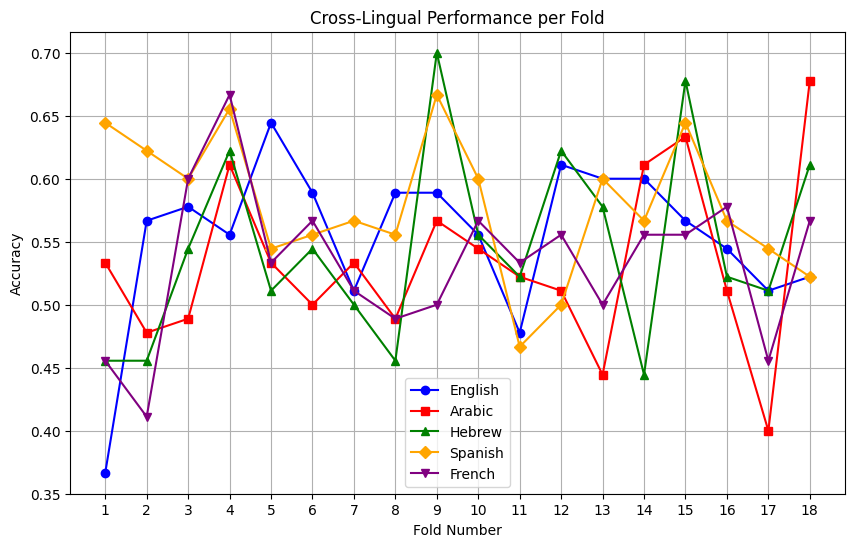

In [30]:
plot_multilingual_performance(fold_results, list(language_embeddings.keys()))

In [31]:
fold_results

[{'fold': 1,
  'english_accuracy': 0.36666666666666675,
  'arabic_accuracy': 0.5333333333333333,
  'hebrew_accuracy': 0.4555555555555556,
  'spanish_accuracy': 0.6444444444444445,
  'french_accuracy': 0.45555555555555555},
 {'fold': 2,
  'english_accuracy': 0.5666666666666667,
  'arabic_accuracy': 0.47777777777777775,
  'hebrew_accuracy': 0.45555555555555555,
  'spanish_accuracy': 0.6222222222222222,
  'french_accuracy': 0.41111111111111115},
 {'fold': 3,
  'english_accuracy': 0.5777777777777778,
  'arabic_accuracy': 0.4888888888888888,
  'hebrew_accuracy': 0.5444444444444445,
  'spanish_accuracy': 0.6,
  'french_accuracy': 0.6},
 {'fold': 4,
  'english_accuracy': 0.5555555555555556,
  'arabic_accuracy': 0.6111111111111113,
  'hebrew_accuracy': 0.6222222222222222,
  'spanish_accuracy': 0.6555555555555556,
  'french_accuracy': 0.6666666666666667},
 {'fold': 5,
  'english_accuracy': 0.6444444444444444,
  'arabic_accuracy': 0.5333333333333333,
  'hebrew_accuracy': 0.5111111111111112,
  's

In [32]:
# Using 18-fold results (more robust)
romance_avg = (0.5790 + 0.5333) / 2  # = 0.5562
semitic_avg = (0.5463 + 0.5327) / 2  # = 0.5395  
germanic_avg = 0.5543

print(f"Romance languages: {romance_avg:.3f}")
print(f"Semitic languages: {semitic_avg:.3f}") 
print(f"Germanic: {germanic_avg:.3f}")

Romance languages: 0.556
Semitic languages: 0.539
Germanic: 0.554


In [ ]:
# # Group by language family
# romance_avg = (spanish_mean + french_mean) / 2
# semitic_avg = (arabic_mean + hebrew_mean) / 2
# germanic_avg = english_mean

# print(f"Romance languages: {romance_avg:.3f}")
# print(f"Semitic languages: {semitic_avg:.3f}") 
# print(f"Germanic: {germanic_avg:.3f}")

In [33]:
# Group languages by family
romance_langs = ['spanish', 'french']
semitic_langs = ['arabic', 'hebrew'] 
germanic_langs = ['english']

# Average performance by language family for each concept
concept_family_performance = {}

for concept in concepts:
    romance_scores = []
    semitic_scores = []
    germanic_scores = []
    
    # Get scores for each family
    for lang in romance_langs:
        if concept in concept_dfs[lang].index:
            romance_scores.append(concept_dfs[lang].loc[concept, 'accuracy'])
    
    for lang in semitic_langs:
        if concept in concept_dfs[lang].index:
            semitic_scores.append(concept_dfs[lang].loc[concept, 'accuracy'])
    
    for lang in germanic_langs:
        if concept in concept_dfs[lang].index:
            germanic_scores.append(concept_dfs[lang].loc[concept, 'accuracy'])
    
    concept_family_performance[concept] = {
        'romance': np.mean(romance_scores) if romance_scores else 0,
        'semitic': np.mean(semitic_scores) if semitic_scores else 0,
        'germanic': np.mean(germanic_scores) if germanic_scores else 0
    }

# Convert to DataFrame for analysis
family_df = pd.DataFrame(concept_family_performance).T

# Find concepts that work best for each family
print("CONCEPTS THAT WORK BEST FOR ROMANCE LANGUAGES:")
romance_best = family_df[family_df['romance'] > family_df[['semitic', 'germanic']].max(axis=1)]
print(romance_best.sort_values('romance', ascending=False).head(10))

print("\nCONCEPTS THAT WORK BEST FOR SEMITIC LANGUAGES:")
semitic_best = family_df[family_df['semitic'] > family_df[['romance', 'germanic']].max(axis=1)]
print(semitic_best.sort_values('semitic', ascending=False).head(10))

print("\nCONCEPTS THAT WORK BEST FOR GERMANIC:")
germanic_best = family_df[family_df['germanic'] > family_df[['romance', 'semitic']].max(axis=1)]
print(germanic_best.sort_values('germanic', ascending=False).head(10))

CONCEPTS THAT WORK BEST FOR ROMANCE LANGUAGES:
            romance   semitic  germanic
weather    1.000000  0.611111  0.111111
war        1.000000  0.888889  0.000000
suspect    1.000000  0.555556  0.444444
plan       1.000000  0.500000  0.222222
pig        1.000000  0.777778  0.555556
movement   1.000000  0.833333  0.666667
invisible  1.000000  0.111111  0.888889
food       1.000000  0.666667  0.666667
plant      0.944444  0.222222  0.444444
fight      0.888889  0.555556  0.555556

CONCEPTS THAT WORK BEST FOR SEMITIC LANGUAGES:
           romance   semitic  germanic
gun       0.611111  1.000000  0.888889
attitude  0.611111  1.000000  0.666667
time      0.777778  1.000000  0.888889
quality   0.611111  1.000000  0.444444
law       0.500000  1.000000  0.000000
feeling   0.500000  1.000000  0.000000
emotion   0.666667  1.000000  0.777778
ball      0.555556  0.944444  0.777778
angry     0.444444  0.944444  0.666667
dance     0.666667  0.944444  0.777778

CONCEPTS THAT WORK BEST FOR GERMANI

## Voxel analyses - which brain regions process words vs sentences?

In [88]:
def load_tuckute_data(csv_path):
    """
    Load and organize Tuckute data to match Pereira format
    """
    # Load the CSV
    df = pd.read_csv(csv_path)
    
    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Unique participants: {df['target_UID'].nunique()}")
    print(f"Unique sentences: {df['item_id'].nunique()}")
    print(f"Unique ROIs: {df['roi'].nunique()}")
    
    # Check what ROIs are available
    print("\nAvailable ROIs:")
    print(df['roi'].value_counts())
    
    return df

# Load your data
tuckute_df = load_tuckute_data('data/brain-lang-data_participant_20230728.csv')

Data shape: (75000, 27)
Columns: ['response_target', 'roi', 'target_UID', 'item_id', 'sentence', 'cond', 'cond_approach', 'encoding_model_pred', 'mapping_result_identifier', 'session_id', 'run_id', 'trial_num', 'run_within_session', 'log-prob-5gram_mean', 'log-prob-gpt2-xl_mean', 'log-prob-pcfg_mean', 'rating_arousal_mean', 'rating_conversational_mean', 'rating_sense_mean', 'rating_gram_mean', 'rating_frequency_mean', 'rating_imageability_mean', 'rating_others_thoughts_mean', 'rating_physical_mean', 'rating_places_mean', 'rating_valence_mean', 'response_target_non_norm']
Unique participants: 10
Unique sentences: 2000
Unique ROIs: 6

Available ROIs:
roi
lang_LH_netw        12500
lang_LH_IFGorb      12500
lang_LH_IFG         12500
lang_LH_MFG         12500
lang_LH_AntTemp     12500
lang_LH_PostTemp    12500
Name: count, dtype: int64


lang: part of the language network.

LH: Left Hemisphere – language is typically left-lateralized in the brain.

lang_LH_netw - Left hemisphere language network (overall network designation)

lang_LH_IFGorb - Left hemisphere Inferior Frontal Gyrus, orbital part (part of Broca's area involved in language production and syntax)

lang_LH_IFG - Left hemisphere Inferior Frontal Gyrus (classic Broca's area for speech production)

lang_LH_MFG - Left hemisphere Middle Frontal Gyrus (supports working memory and executive control in language processing)

lang_LH_AntTemp - Left hemisphere Anterior Temporal cortex (semantic processing, word meaning, and conceptual knowledge)

lang_LH_PostTemp - Left hemisphere Posterior Temporal cortex (involved in auditory language comprehension and phonological processing)

In [108]:
np.max(exp1_data.values)

198.59337714916165

In [106]:
def prepare_tuckute_data(tuckute_df):
    """
    Prepare Tuckute data for analysis
    """
    # Average across participants for each sentence and ROI
    avg_data = tuckute_df.groupby(['item_id', 'sentence', 'roi'])['response_target'].mean().reset_index()
    
    # Pivot to get sentences × ROIs format
    fmri_matrix = avg_data.pivot(index='item_id', columns='roi', values='response_target')
    
    # Get sentences in order
    sentences_df = avg_data[['item_id', 'sentence']].drop_duplicates().sort_values('item_id')
    
    print(f"Tuckute fMRI matrix shape: {fmri_matrix.shape}")
    print(f"ROIs: {list(fmri_matrix.columns)}")
    
    return fmri_matrix.values, sentences_df['sentence'].values, list(fmri_matrix.columns)

tuckute_fmri, tuckute_sentences, roi_names = prepare_tuckute_data(tuckute_df)

Tuckute fMRI matrix shape: (2000, 6)
ROIs: ['lang_LH_AntTemp', 'lang_LH_IFG', 'lang_LH_IFGorb', 'lang_LH_MFG', 'lang_LH_PostTemp', 'lang_LH_netw']


In [112]:
len(tuckute_fmri)

2000

In [113]:
tuckute_fmri

array([[-0.06673879,  0.08338155, -0.00825171,  0.03048193,  0.06660142,
         0.02617496],
       [ 0.29418343,  0.22987394,  0.59515717,  0.10842205,  0.09981215,
         0.19733172],
       [-0.21433658, -0.03990172, -0.41431147,  0.02696916, -0.15225063,
        -0.15705901],
       ...,
       [-0.65398261, -0.31916958, -0.58894666, -0.53892583, -0.56025562,
        -0.55580689],
       [-0.79187813, -0.17620916, -0.02281924, -0.98587555, -0.9209685 ,
        -0.74741966],
       [-0.46799134, -0.5598958 , -0.43992208, -0.62760861, -0.74259044,
        -0.62092964]])

In [111]:
len(tuckute_sentences)

2000

##### Look for active voxels

In [195]:
# def select_active_voxels(fmri_data, percentile=90):
#     """
#     Select voxels that actually respond to stimuli - top 10%
    
#     Args:
#         fmri_data: Shape (180, 185866) - concepts × voxels
#         percentile: Keep top X% most variable voxels
    
#     Returns:
#         active_voxel_indices: Indices of selected voxels
#         active_voxel_data: Data for just active voxels
#     """
#     # cal variance for each voxel across concepts
#     voxel_variance = np.var(fmri_data, axis=0)
    
#     threshold = np.percentile(voxel_variance, percentile)
    
#     # Find voxels above threshold
#     active_voxel_indices = np.where(voxel_variance > threshold)[0]
    
#     # Extract data for just these voxels
#     active_voxel_data = fmri_data[:, active_voxel_indices]
    
#     print(f"Selected {len(active_voxel_indices)} active voxels out of {fmri_data.shape[1]}")
#     print(f"Variance threshold: {threshold:.4f}")
    
#     return active_voxel_indices, active_voxel_data

# # active_indices, active_data = select_active_voxels(exp1_data.values, percentile=90)

# active_indices, active_data = select_active_voxels(exp2_fmri, percentile=90)


def select_active_voxels_both_experiments(exp1_data, exp2_fmri, percentile=90):
    """
    Select voxels that are active in EITHER words OR sentences
    """
    # Variance in each experiment
    var_exp1 = np.var(exp1_data, axis=0)
    var_exp2 = np.var(exp2_fmri, axis=0)
    
    # Combined activity measure
    combined_variance = np.maximum(var_exp1, var_exp2)  # Active in either
    # OR
    # combined_variance = (var_exp1 + var_exp2) / 2  # Average activity
    
    threshold = np.percentile(combined_variance, percentile)
    active_indices = np.where(combined_variance > threshold)[0]
    
    print(f"Selected {len(active_indices)} voxels active in either experiment")
    return active_indices


active_indices = select_active_voxels_both_experiments(exp1_data.values, exp2_fmri, percentile=90)

Selected 18587 voxels active in either experiment


##### Cluster voxels

In [ ]:
def cluster_voxels(active_voxel_data, n_clusters=10, method='kmeans'):
    """
    Cluster voxels based on their activation patterns
    
    Args:
        active_voxel_data: Shape (180, n_active_voxels)
        n_clusters: Number of clusters
        method: 'kmeans', 'meanshift', or 'hierarchical'
    
    Returns:
        cluster_labels: Cluster assignment for each voxel
        cluster_centers: Center of each cluster (if applicable)
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
    
    voxel_patterns = active_voxel_data.T
    
    
    scaler = StandardScaler()
    voxel_patterns_scaled = scaler.fit_transform(voxel_patterns)
    
    print(f"Clustering {voxel_patterns.shape[0]} voxels using {method}...")
    
    if method == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = clusterer.fit_predict(voxel_patterns_scaled)
        cluster_centers = clusterer.cluster_centers_
        
    elif method == 'meanshift':
        # finds number of clusters automatically
        clusterer = MeanShift(bandwidth=None)
        cluster_labels = clusterer.fit_predict(voxel_patterns_scaled)
        cluster_centers = clusterer.cluster_centers_
        n_clusters = len(np.unique(cluster_labels))
        print(f"MeanShift found {n_clusters} clusters")
        
    elif method == 'hierarchical':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(voxel_patterns_scaled)
        cluster_centers = None
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    
    print("\nCluster sizes:")
    for i in range(max(cluster_labels) + 1):
        size = np.sum(cluster_labels == i)
        print(f"  Cluster {i}: {size} voxels")
    
    return cluster_labels, cluster_centers


labels, centers = cluster_voxels(active_data, n_clusters=10, method='kmeans')

Clustering 18587 voxels using kmeans...

Cluster sizes:
  Cluster 0: 1762 voxels
  Cluster 1: 2012 voxels
  Cluster 2: 3171 voxels
  Cluster 3: 3561 voxels
  Cluster 4: 2223 voxels
  Cluster 5: 556 voxels
  Cluster 6: 820 voxels
  Cluster 7: 824 voxels
  Cluster 8: 1796 voxels
  Cluster 9: 1862 voxels


Clustering 18587 voxels using kmeans...

Cluster sizes:
  Cluster 0: 2019 voxels \
  Cluster 1: 1772 voxels \
  Cluster 2: 1867 voxels \
  Cluster 3: 2093 voxels \
  Cluster 4: 3350 voxels \
  Cluster 5: 3359 voxels \
  Cluster 6: 217 voxels \
  Cluster 7: 1343 voxels \
  Cluster 8: 743 voxels \
  Cluster 9: 1824 voxels \

Clustering 18587 voxels using meanshift... \
MeanShift found 5 clusters \
Cluster sizes: \
  Cluster 0: 18325 voxels \
  Cluster 1: 41 voxels \
  Cluster 2: 191 voxels \
  Cluster 3: 12 voxels \
  Cluster 4: 18 voxels \


Clustering 18587 voxels using hierarchical...

Cluster sizes: \
  Cluster 0: 4634 voxels \
  Cluster 1: 1759 voxels \
  Cluster 2: 2682 voxels \
  Cluster 3: 1532 voxels \
  Cluster 4: 1691 voxels \
  Cluster 5: 2588 voxels \
  Cluster 6: 2212 voxels \
  Cluster 7: 147 voxels \
  Cluster 8: 470 voxels \
  Cluster 9: 872 voxels \

##### Mapping

In [197]:
# keyPassageCategory = exp2_data['keyPassageCategory'][0]  # 24 broad topics
# keyPassages = exp2_data['keyPassages']  # 96 passage names --> 96 * 4 (sentences per passages) = 384
# labelsPassageCategory = exp2_data['labelsPassageCategory']  # topic id for each passage, 96
# labelsPassageForEachSentence = exp2_data['labelsPassageForEachSentence']  # passage id for each sentence, 384

# sentence_topics = []
# sentence_passages = []

# for sent_idx in range(384):
#     passage_id = labelsPassageForEachSentence[sent_idx][0]
#     topic_id = labelsPassageCategory[passage_id - 1][0]
#     topic_name = keyPassageCategory[topic_id - 1]
#     passage_name = keyPassages[passage_id - 1]
#     sentence_topics.append(topic_name)
#     sentence_passages.append(passage_name)
    
    
    
# df = pd.DataFrame({
#     'sentence': [s.strip() for s in exp2_sentences],
#     'topic': sentence_topics,
#     'passage': sentence_passages,
# })

# # get rid of brackets around topic and passage 
# df['topic'] = df['topic'].apply(lambda x: x[0])
# df['passage'] = df['passage'].apply(lambda x: x[0][0])
# df

In [198]:
def analyze_all_sentences(exp1_data, exp2_fmri, active_indices, cluster_labels):
    """
    Compare word vs sentence activation without requiring exact matches
    """
    n_clusters = max(cluster_labels) + 1
    
    for cluster_id in range(n_clusters):
        # Get voxels in this cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_voxel_indices = active_indices[cluster_mask]
        
        # Average activation across all stimuli
        word_activation = np.mean(exp1_data[:, cluster_voxel_indices])
        sentence_activation = np.mean(exp2_fmri[:, cluster_voxel_indices])
        
        # Variance (how selective is this cluster?)
        word_variance = np.var(np.mean(exp1_data[:, cluster_voxel_indices], axis=1))
        sentence_variance = np.var(np.mean(exp2_fmri[:, cluster_voxel_indices], axis=1))
        
        print(f"\nCluster {cluster_id}:")
        print(f"  Word activation: mean={word_activation:.3f}, var={word_variance:.3f}")
        print(f"  Sentence activation: mean={sentence_activation:.3f}, var={sentence_variance:.3f}")
        print(f"  Preference: {'Sentences' if sentence_activation > word_activation else 'Words'}")

In [199]:
analyze_all_sentences(exp1_data.values, exp2_fmri, active_indices, labels)


Cluster 0:
  Word activation: mean=2.578, var=23.745
  Sentence activation: mean=2.732, var=29.281
  Preference: Sentences

Cluster 1:
  Word activation: mean=0.172, var=31.574
  Sentence activation: mean=-0.125, var=41.004
  Preference: Words

Cluster 2:
  Word activation: mean=0.547, var=26.296
  Sentence activation: mean=0.289, var=25.208
  Preference: Words

Cluster 3:
  Word activation: mean=2.324, var=13.528
  Sentence activation: mean=1.666, var=16.598
  Preference: Words

Cluster 4:
  Word activation: mean=1.610, var=21.022
  Sentence activation: mean=1.199, var=27.496
  Preference: Words

Cluster 5:
  Word activation: mean=0.996, var=17.820
  Sentence activation: mean=1.162, var=22.440
  Preference: Sentences

Cluster 6:
  Word activation: mean=1.789, var=16.588
  Sentence activation: mean=0.017, var=22.785
  Preference: Words

Cluster 7:
  Word activation: mean=2.281, var=25.171
  Sentence activation: mean=1.738, var=16.395
  Preference: Words

Cluster 8:
  Word activation: 

In [200]:
def analyze_word_vs_sentence_processing(exp1_data, exp2_fmri, active_indices, cluster_labels):
    """
    Compare how each cluster responds to words vs sentences
    without requiring concept matching
    """
    n_clusters = max(cluster_labels) + 1
    results = []
    
    print("=== WORD vs SENTENCE PROCESSING ANALYSIS ===\n")
    
    for cluster_id in range(n_clusters):
        # Get voxels in this cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_voxel_indices = active_indices[cluster_mask]
        
        # Get activation for this cluster
        word_activations = exp1_data[:, cluster_voxel_indices]  # 180 words × cluster voxels
        sentence_activations = exp2_fmri[:, cluster_voxel_indices]  # 384 sentences × cluster voxels
        
        # Average across voxels in cluster
        word_pattern = np.mean(word_activations, axis=1)  # 180 values
        sentence_pattern = np.mean(sentence_activations, axis=1)  # 384 values
        
        # Calculate statistics
        word_mean = np.mean(word_pattern)
        word_std = np.std(word_pattern)
        sentence_mean = np.mean(sentence_pattern)
        sentence_std = np.std(sentence_pattern)
        
        # Which type of stimulus drives more variance? (indicates selectivity)
        word_selectivity = word_std / (abs(word_mean) + 1e-5)
        sentence_selectivity = sentence_std / (abs(sentence_mean) + 1e-5)
        
        results.append({
            'cluster_id': cluster_id,
            'n_voxels': len(cluster_voxel_indices),
            'word_mean': word_mean,
            'word_std': word_std,
            'sentence_mean': sentence_mean,
            'sentence_std': sentence_std,
            'word_selectivity': word_selectivity,
            'sentence_selectivity': sentence_selectivity,
            'prefers_sentences': sentence_mean > word_mean,
            'more_selective_for': 'sentences' if sentence_selectivity > word_selectivity else 'words'
        })
        
        print(f"Cluster {cluster_id} ({len(cluster_voxel_indices)} voxels):")
        print(f"  Words:     mean={word_mean:6.2f}, std={word_std:6.2f}, selectivity={word_selectivity:.2f}")
        print(f"  Sentences: mean={sentence_mean:6.2f}, std={sentence_std:6.2f}, selectivity={sentence_selectivity:.2f}")
        print(f"  → Prefers: {'SENTENCES' if sentence_mean > word_mean else 'WORDS'}")
        print(f"  → More selective for: {'SENTENCES' if sentence_selectivity > word_selectivity else 'WORDS'}")
        print()
    
    return results

word_vs_sentence_results = analyze_word_vs_sentence_processing(
    exp1_data.values, exp2_fmri, active_indices, labels
)

=== WORD vs SENTENCE PROCESSING ANALYSIS ===

Cluster 0 (1762 voxels):
  Words:     mean=  2.58, std=  4.87, selectivity=1.89
  Sentences: mean=  2.73, std=  5.41, selectivity=1.98
  → Prefers: SENTENCES
  → More selective for: SENTENCES

Cluster 1 (2012 voxels):
  Words:     mean=  0.17, std=  5.62, selectivity=32.68
  Sentences: mean= -0.13, std=  6.40, selectivity=51.13
  → Prefers: WORDS
  → More selective for: SENTENCES

Cluster 2 (3171 voxels):
  Words:     mean=  0.55, std=  5.13, selectivity=9.37
  Sentences: mean=  0.29, std=  5.02, selectivity=17.35
  → Prefers: WORDS
  → More selective for: SENTENCES

Cluster 3 (3561 voxels):
  Words:     mean=  2.32, std=  3.68, selectivity=1.58
  Sentences: mean=  1.67, std=  4.07, selectivity=2.45
  → Prefers: WORDS
  → More selective for: SENTENCES

Cluster 4 (2223 voxels):
  Words:     mean=  1.61, std=  4.59, selectivity=2.85
  Sentences: mean=  1.20, std=  5.24, selectivity=4.38
  → Prefers: WORDS
  → More selective for: SENTENCES

Cl

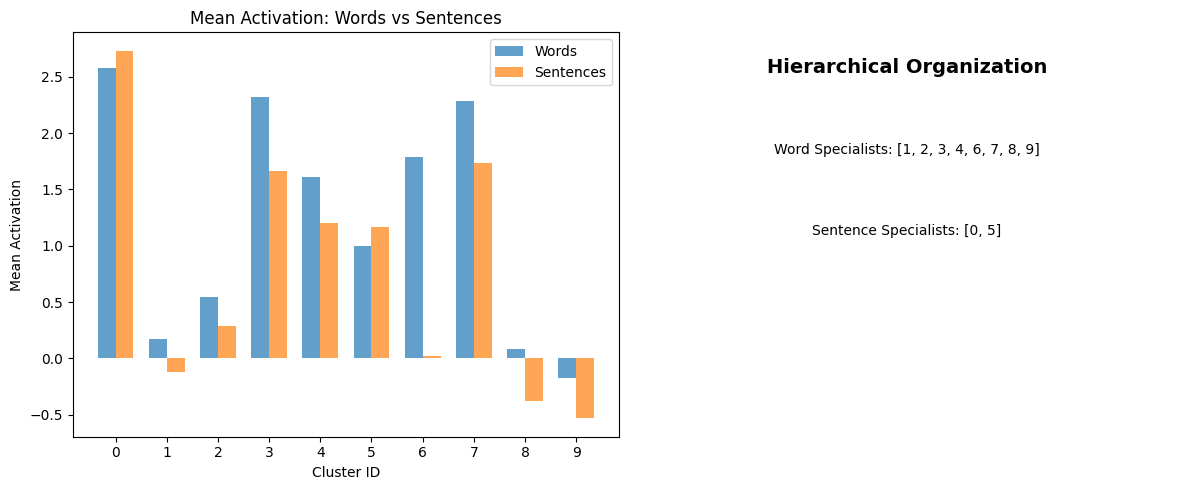

In [201]:
def visualize_hierarchy(results):
    """
    Create a clear visualization of word vs sentence preferences
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    cluster_ids = [r['cluster_id'] for r in results]
    word_means = [r['word_mean'] for r in results]
    sentence_means = [r['sentence_mean'] for r in results]
    word_selectivity = [r['word_selectivity'] for r in results]
    sentence_selectivity = [r['sentence_selectivity'] for r in results]
    n_voxels = [r['n_voxels'] for r in results]
    
    x = np.arange(len(cluster_ids))
    width = 0.35
    
    axes[0].bar(x - width/2, word_means, width, label='Words', alpha=0.7)
    axes[0].bar(x + width/2, sentence_means, width, label='Sentences', alpha=0.7)
    axes[0].set_xlabel('Cluster ID')
    axes[0].set_ylabel('Mean Activation')
    axes[0].set_title('Mean Activation: Words vs Sentences')
    axes[0].legend()
    axes[0].set_xticks(x)
    
    axes[1].text(0.5, 0.9, 'Hierarchical Organization',
                ha='center', fontsize=14, weight='bold')
    
    word_clusters = [r['cluster_id'] for r in results if not r['prefers_sentences']]
    sentence_clusters = [r['cluster_id'] for r in results if r['prefers_sentences']]
    
    axes[1].text(0.5, 0.7, f'Word Specialists: {word_clusters}', ha='center')
    axes[1].text(0.5, 0.5, f'Sentence Specialists: {sentence_clusters}', ha='center')
    
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_hierarchy(word_vs_sentence_results)

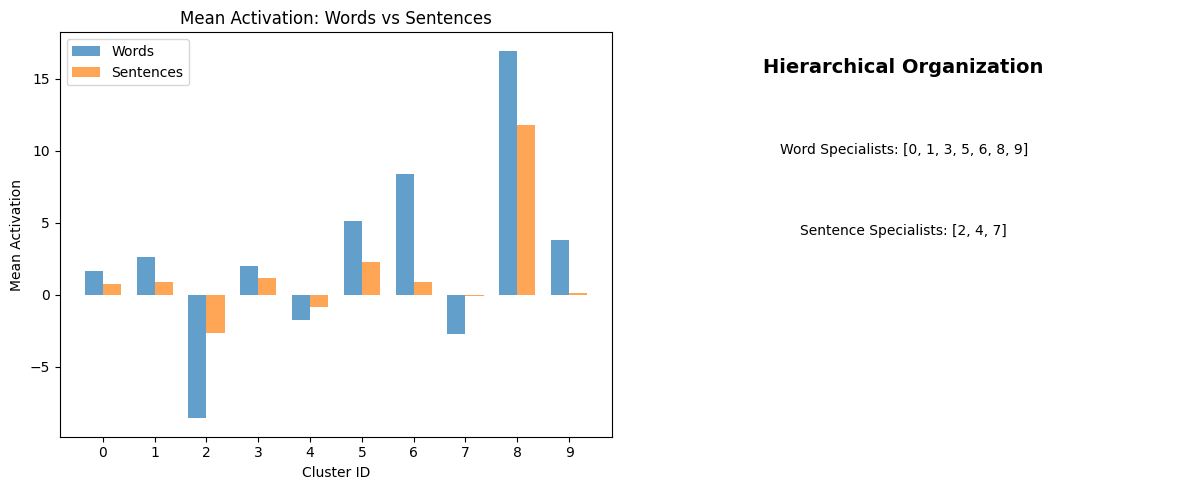

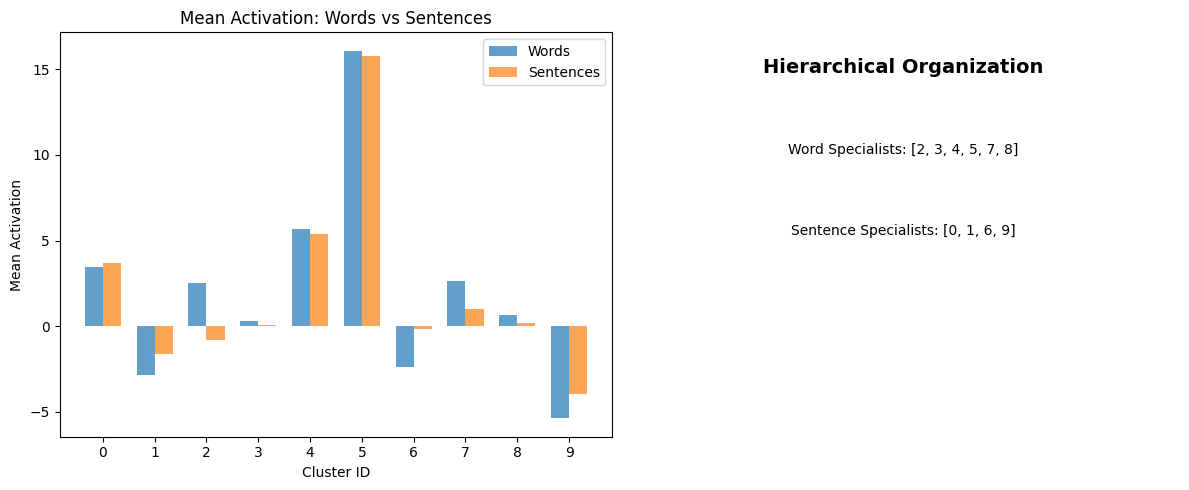